In [ ]:
%%capture
!pip install fastai --upgrade
!pip install fastbook
!pip install utils

In [1]:
from utils import *
from fastai.vision.all import *
from fastai.vision.widgets import *

## Gathering Data

We will download images with Bing Image Search. It requires signing up at Microsoft for a free account. We will be given a key, which you can copy and enter as follows (replacing 'xxx' with your key):

In [2]:
key = 'xxx'

In [3]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [4]:
results = search_images_bing(key, 'stratocaster') # useful fastai function to browse the bing image search engine
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
dest = 'images/stratocaster.jpg'
download_url(ims[0], dest)

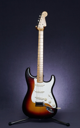

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

In [44]:
guitar_types = 'stratocaster','telecaster'
path = Path('guitar')

In [8]:
if not path.exists():
    path.mkdir()
    for o in guitar_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [9]:
fns = get_image_files(path)
fns

(#300) [Path('guitar/stratocaster/00000004.jpg'),Path('guitar/stratocaster/00000005.jpg'),Path('guitar/stratocaster/00000007.JPG'),Path('guitar/stratocaster/00000000.jpg'),Path('guitar/stratocaster/00000002.jpg'),Path('guitar/stratocaster/00000008.jpg'),Path('guitar/stratocaster/00000001.jpg'),Path('guitar/stratocaster/00000010.jpg'),Path('guitar/stratocaster/00000013.jpg'),Path('guitar/stratocaster/00000009.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#1) [Path('guitar/telecaster/00000009.jpg')]

Let's delete the images that do not match with the names that we got

In [11]:
failed.map(Path.unlink);

## Create DataLoaders

In [45]:
guitars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=41),
    get_y=parent_label,
    item_tfms=Resize(128))

This has given us a template for creating `DataLoaders`

In [46]:
dls = guitars.dataloaders(path)

`dls = DataBlock.dataloaders()`

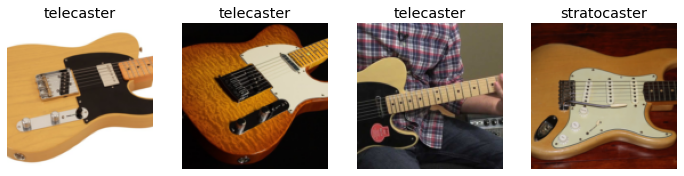

In [5]:
dls.valid.show_batch(max_n=4, nrows=1)

## Let's try different resizing methods to get optimal results

`guitars.new` **is a method that creates an identical copy of the DataBlock created before. Use to experiment.**

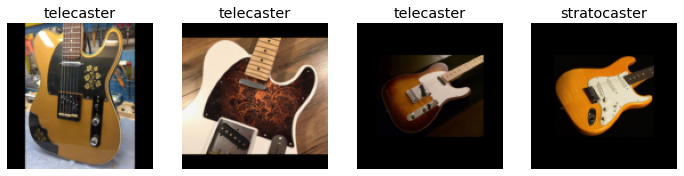

In [21]:
guitars = guitars.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = guitars.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

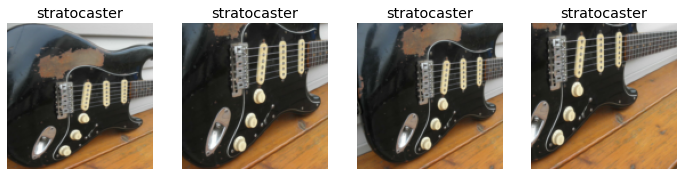

In [47]:
guitars = guitars.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = guitars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Here, for each epoch, the same images get randomly cropped to contain just a certain part of the image. This way, we keep our images looking natural and make our model see the same objects in slightly different places, which is how it normally works in the real world.

### Data Augmentation

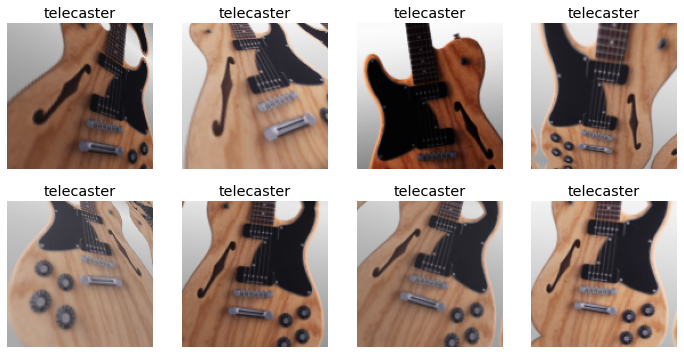

In [18]:
guitars = guitars.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = guitars.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the model

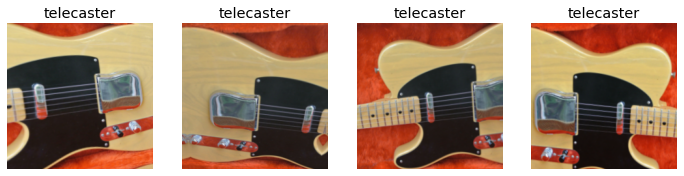

In [58]:
guitars = guitars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # min_scale=0.5 means we keep at least 50% of px of the original image
    batch_tfms=aug_transforms())
dls = guitars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

**All of the augmentation transforms will be applied only to the training set, leaving the validation set untouched. However, RandomResizeCrop will affect the validation set as well.**

In [53]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(9)

epoch,train_loss,valid_loss,error_rate,time
0,1.107231,1.140489,0.438596,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.676812,0.526048,0.280702,00:06
1,0.592445,0.327728,0.122807,00:06
2,0.523951,0.274083,0.140351,00:06
3,0.440803,0.254241,0.122807,00:06
4,0.380512,0.255091,0.105263,00:06
5,0.339644,0.268072,0.087719,00:06
6,0.306847,0.283389,0.087719,00:06
7,0.272074,0.293605,0.087719,00:05
8,0.259875,0.308414,0.087719,00:06


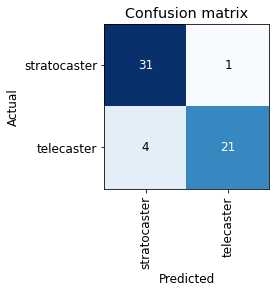

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

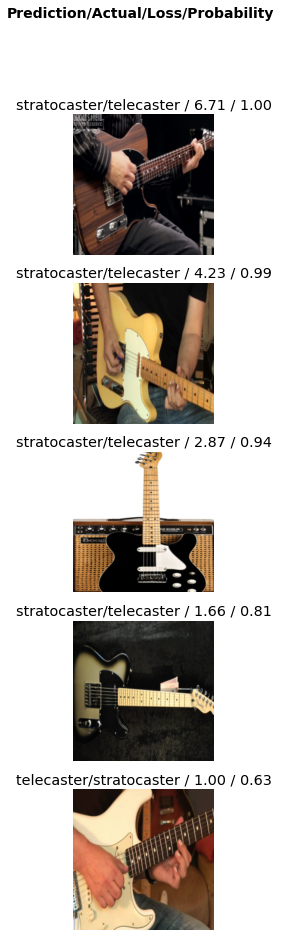

In [55]:
interp.plot_top_losses(5, nrows=5)

## Let's clean our data using the model results

**Clean your data after lauching your model! It's easier!**

It picks images where the loss is greater.

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [59]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #this deletes the file
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) #this moves the file to the correct directory

## Export the model for later inference in a web app

In [56]:
learn.export()

In [57]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

This is how we will load it later:

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab